In [1]:
 
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#


## Simple FDK and TV examples

Note that the data is heavily downsampled to speed up the computations.

In [2]:

import cil
print(f"Using CIL version {cil.__version__}")

Using CIL version 24.2.0


In [3]:
from util.pcaReader import read_pca_file
path = "../wago/"
filepath = path + 'wago.pca'
params = read_pca_file(filepath)

202 lines, found 148 values (discarded 129)


In [4]:
# # remove some annoying warnings
# import logging
# logger = logging.getLogger('dxchange')
# logger.setLevel(logging.ERROR)

First import all of the modules we will need:

In [5]:
import os
import numpy as np

# cil imports
from cil.framework import AcquisitionGeometry

from cil.optimisation.functions import LeastSquares, TotalVariation
from cil.optimisation.algorithms import FISTA

from cil.plugins.astra import ProjectionOperator

from cil.utilities.display import show2D, show_geometry
from cil.utilities.jupyter import islicer

from cil.io import TIFFStackReader


## Create geometry

We have to manually set the values for the correct geometry. These can be found in the documentation of the data.

In [6]:
# Acquisition geometry parameters
SOD = params["FOD"] # Source-Origin-distance
print(f'SOD: {SOD:.3f} mm')
SDD = params["FDD"] # Source-Detector-distance
print(f'SDD: {SDD:.3f} mm')
ODD = SDD - SOD # Origin-detector-distance
print(f'ODD: {ODD:.3f} mm')
pixelSize = 200 / 1000 # Raw detector pixel size
print(f'Detector pixel size: {pixelSize:.3f} mm')

num_pixels = (params["DimX"], params["DimY"]) # Projection image width and height
num_pixels = (num_pixels[0], num_pixels[1])
print(f"Original projection image size: {params["DimX"]} x {params["DimY"]}, set to: {num_pixels[0]} x {num_pixels[1]}")
num_images = params["NumberImages"]
print(f"{num_images} projection angles used")

SOD: 68.914 mm
SDD: 648.629 mm
ODD: 579.715 mm
Detector pixel size: 0.200 mm
Original projection image size: 1000.0 x 1000.0, set to: 1000.0 x 1000.0
1320 projection angles used


## Detector and rotation angles

In [7]:
skip = 10 # Angular downsampling
angles = np.linspace(0., 360., num_images//skip, endpoint=False)
ag_big = AcquisitionGeometry.create_Cone3D([0,-SOD, 0], [0,ODD, 0], units='mm', 
                                           detector_direction_x=[1, 0, 0], 
                                           rotation_axis_direction=[0, 0, 1])
ag_big.set_panel(num_pixels, pixel_size=(pixelSize, pixelSize), origin='bottom-right')
ag_big.set_angles(angles)
ag_big.set_labels(('angle', 'vertical', 'horizontal'))
print(ag_big)

3D Cone-beam tomography
System configuration:
	Source position: [  0.        , -68.91383333,   0.        ]
	Rotation axis position: [0., 0., 0.]
	Rotation axis direction: [0., 0., 1.]
	Detector position: [  0.        , 579.71548167,   0.        ]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [1000 1000]
	Pixel size: [0.2 0.2]
	Pixel origin: bottom-right
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 132
	Angles 0-9 in degrees: [ 0.       ,  2.7272727,  5.4545455,  8.181818 , 10.909091 , 13.636364 ,
 16.363636 , 19.09091  , 21.818182 , 24.545454 ]
	Angles 122-131 in degrees: [332.72726, 335.45456, 338.18182, 340.9091 , 343.63635, 346.36365,
 349.0909 , 351.81818, 354.54544, 357.27274]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: mm


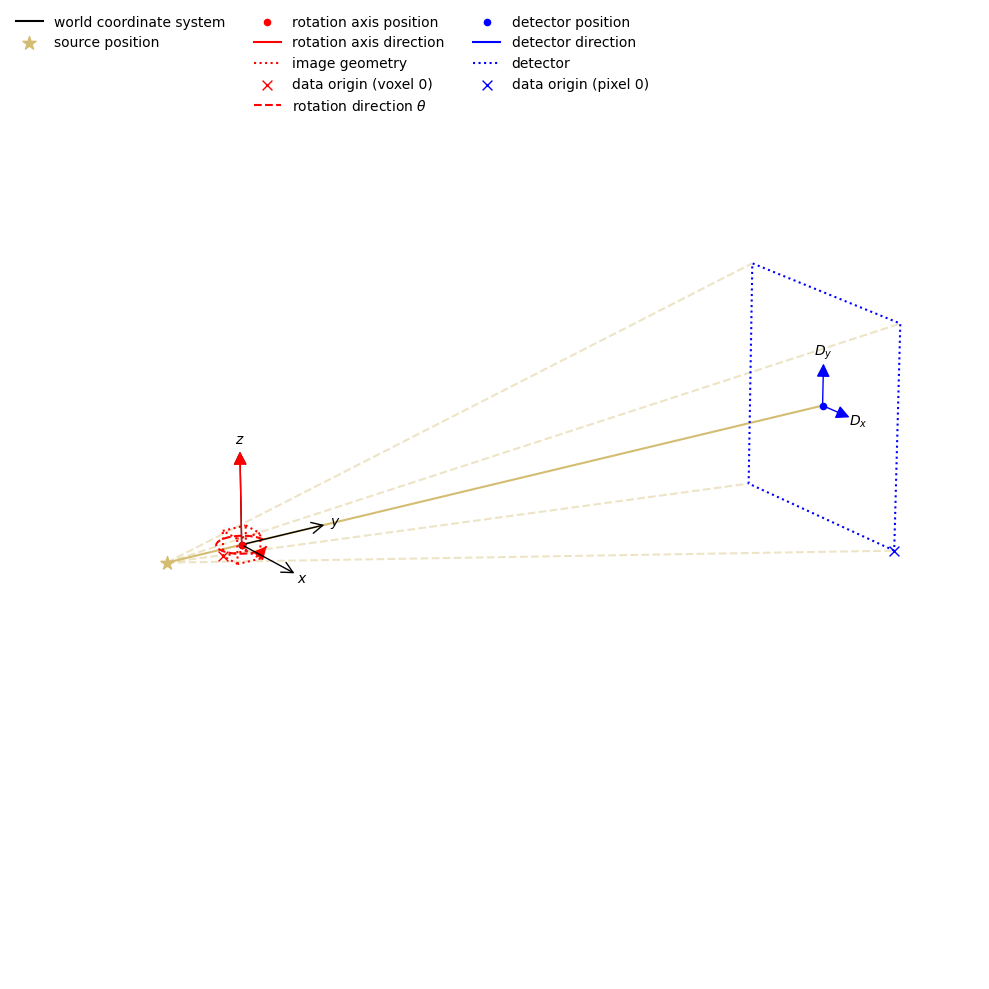

In [8]:
show_geometry(ag_big);

### Read data and add geometry

In [9]:
roi = {'axis_0': (0,num_images,skip), 'axis_1': -1, 'axis_2': (0,1000,1)}
reader = TIFFStackReader(file_name=path, transpose=False, roi=roi)

In [10]:
big_raw_data = reader.read_as_AcquisitionData(ag_big)
del reader

Number of dimensions: 3
Shape: (132, 1000, 1000)
Axis labels: (<AcquisitionDimension.ANGLE: 'angle'>, <AcquisitionDimension.VERTICAL: 'vertical'>, <AcquisitionDimension.HORIZONTAL: 'horizontal'>)



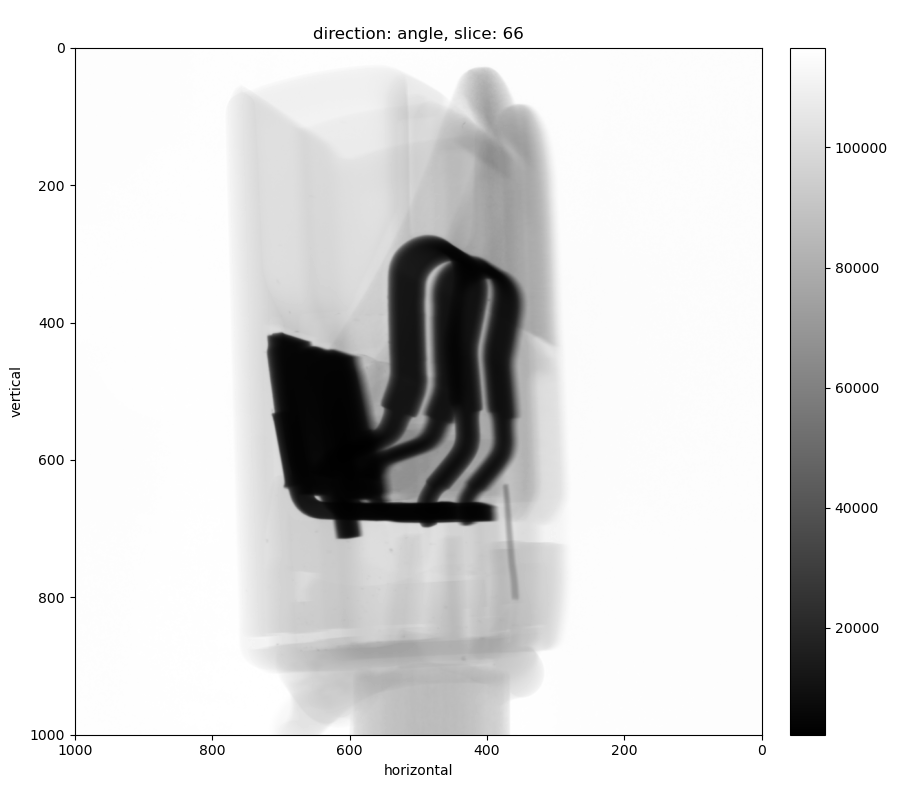

In [11]:
print(big_raw_data)
show2D(big_raw_data, origin="upper-right");

In [12]:
islicer(big_raw_data)

### Process the data
We want to bin the data to smaller resolution and convert from transmission to absorption images

max_k = 11602, about 17.703 % of the maximum (of 16 bit int)


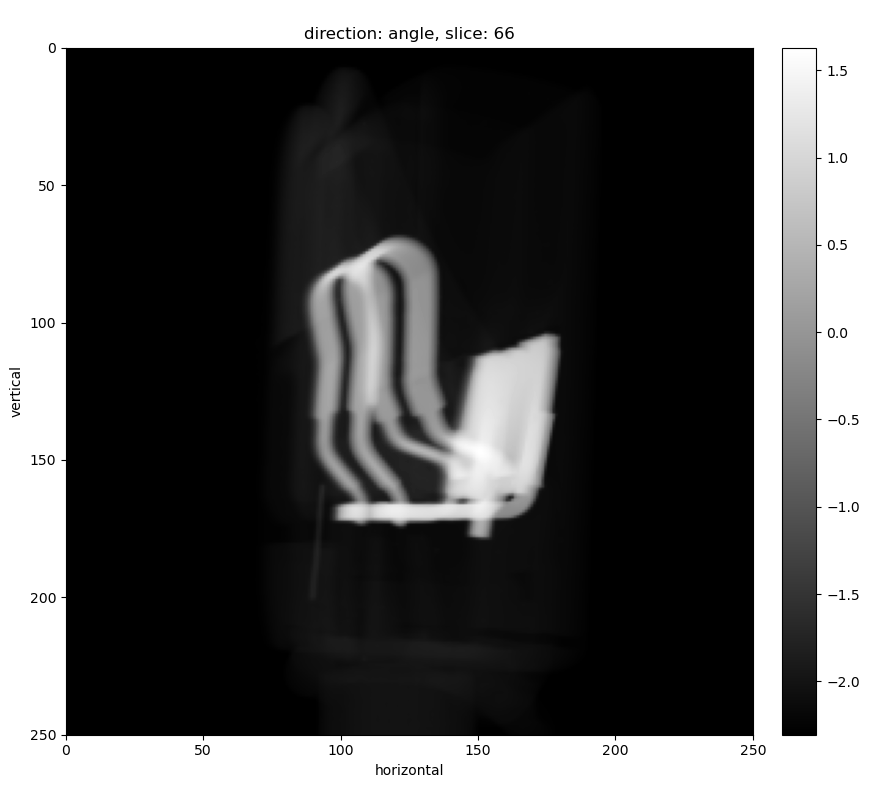

Number of dimensions: 3
Shape: (132, 250, 250)
Axis labels: (<AcquisitionDimension.ANGLE: 'angle'>, <AcquisitionDimension.VERTICAL: 'vertical'>, <AcquisitionDimension.HORIZONTAL: 'horizontal'>)



In [ ]:
from cil.processors import Binner, TransmissionAbsorptionConverter


binning = 4 # xy-downsampling of projection images.
binner_processor = Binner(roi={'horizontal': (None, None, binning), 'vertical': (None, None, binning)})
binner_processor.set_input(big_raw_data)
data = binner_processor.get_output()

# Get the raw intensity from the mean of the k largest values
# k = 100
# max_k = np.partition(data.as_array(), -k, axis=None)[-k:].mean()
# 
max_k = params["FreeRay"]
print(f"{max_k = }, about {100*max_k / 2**14:.3f} % of the maximum (of 14 bit int)")
transmission_processor = TransmissionAbsorptionConverter(white_level=max_k)
transmission_processor.set_input(data)
transmission_processor.get_output(out=data)

show2D(data, origin="upper-left")
print(data)

In [14]:
islicer(data)

In [15]:
del big_raw_data
del binner_processor
del transmission_processor

### Image geometry and data

In [16]:
# Setup image geometry
(_, nz, nx) = data.shape
ig = data.geometry.get_ImageGeometry()
ig.voxel_num_x = nx
ig.voxel_num_y = nx
ig.voxel_num_z = nz
print(ig)

Number of channels: 1
channel_spacing: 1.0
voxel_num : x250,y250,z250
voxel_size : x0.08499626117576878,y0.08499626117576878,z0.08499626117576878
center : x0,y0,z0



# Reconstructions

## FDK reconstruction

In [17]:
from cil.recon import FDK

data.reorder('tigre')
fdk = FDK(data)

fdk_recon = fdk.run()

FDK recon

Input Data:
	angle: 132
	vertical: 250
	horizontal: 250

Reconstruction Volume:
	vertical: 250
	horizontal_y: 250
	horizontal_x: 250

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 9
	Filter_inplace: False



(250, 250, 250)


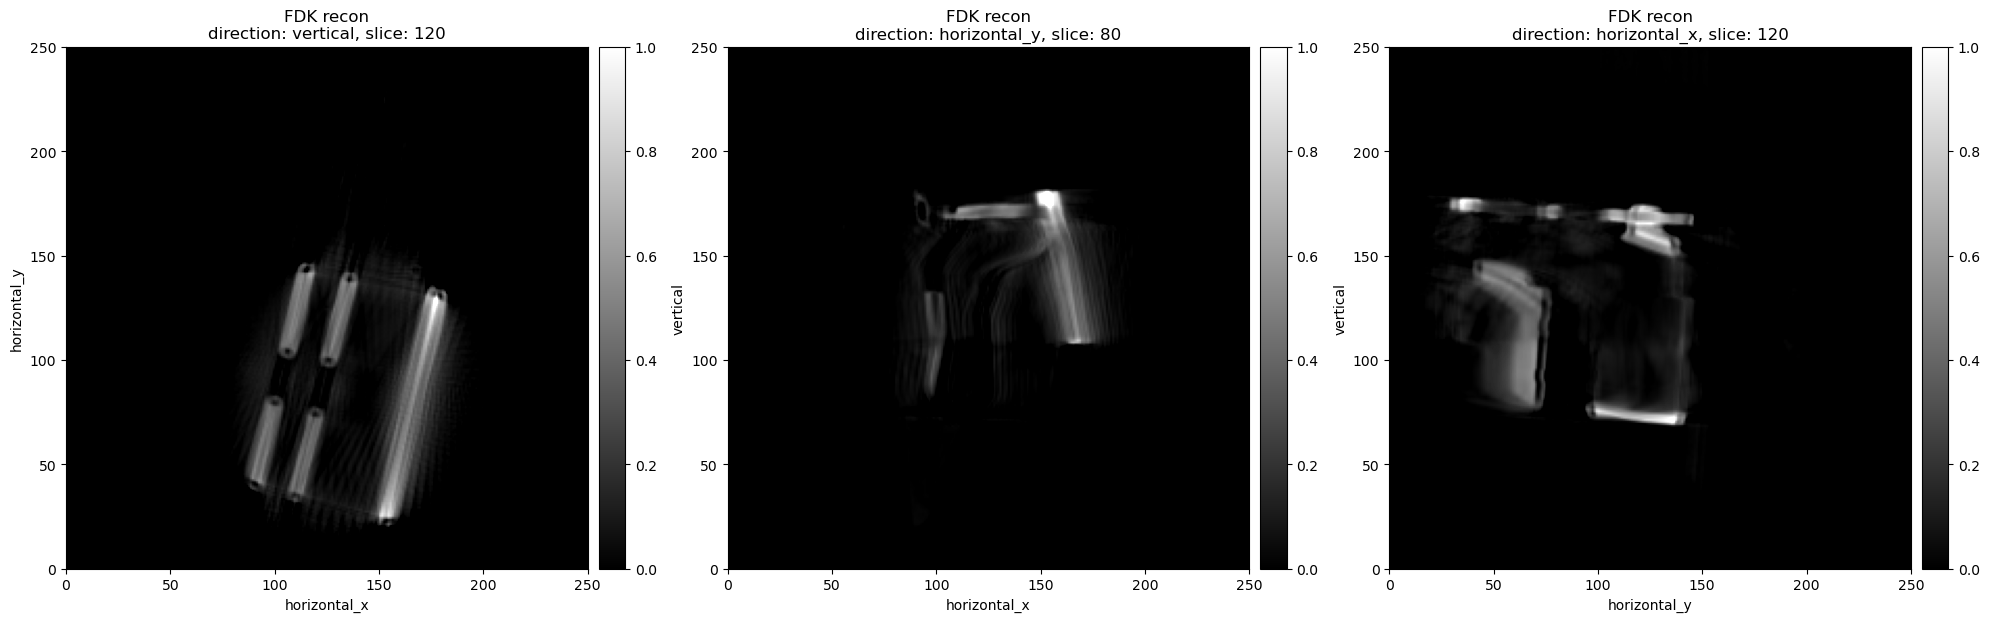

In [18]:
print(fdk_recon.shape)
ub = 1 # Upper bound
show2D(fdk_recon, size=(20,10), fix_range=(0,ub), title=f"FDK recon", num_cols=3, slice_list=[(0, 120), (1, 80), (2, 120)]);

In [19]:
islicer(fdk_recon, size=(10,10), title=f"FDK reconstruction", minmax=(0,ub))

## Total Variation (TV) reconstruction

In [20]:
data.reorder('astra')
ag = data.geometry

A = ProjectionOperator(ig, ag, 'gpu')
f = LeastSquares(A, data)

h = TotalVariation()
alpha = 1e-5 # Regularization parameter

tv_fista = FISTA(initial=ig.allocate(0), f=f, g=alpha*h)

In [21]:
tv_fista.run(20)

  0%|          | 0/20 [00:00<?, ?it/s]

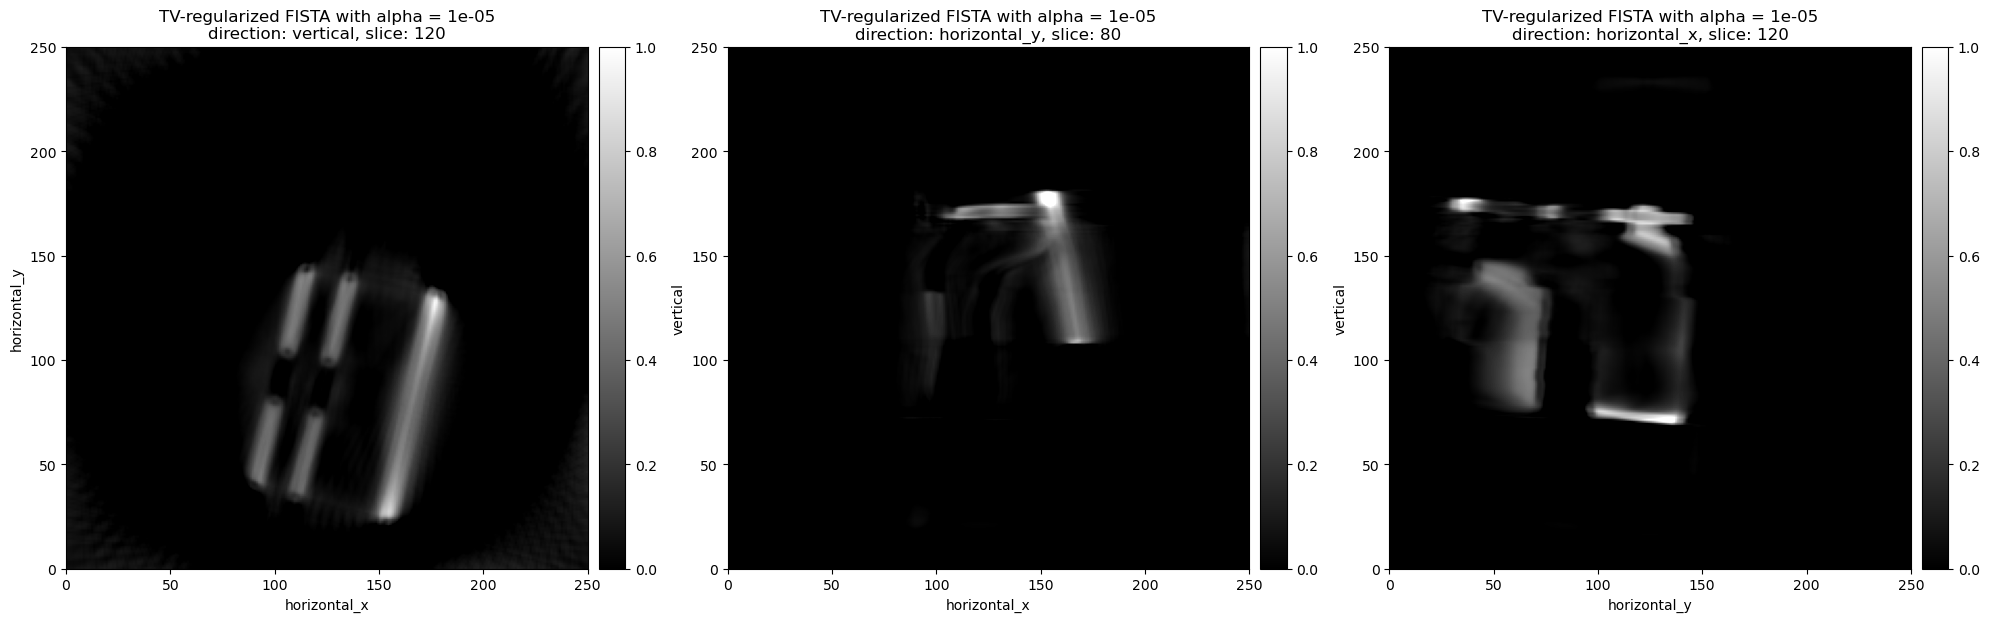

In [22]:
x_tv = tv_fista.get_output()
show2D(x_tv, size=(20,10), fix_range=(0,ub), title=f"TV-regularized FISTA with {alpha = }", num_cols=3, slice_list=[(0, 120), (1, 80), (2, 120)]);